In [1]:
from utils import wandb_to_beaker_result, beaker_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from scipy.signal import butter, lfilter
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
with open("wandb_ids.yaml", "r") as f:
    wandb_ids = yaml.safe_load(f)
wandb_id = wandb_ids['era5-co2-10yr-RS2-IC0-ni']
wandb_id_climSST = wandb_ids['era5-co2-10yr-climSST-precip-only']
beaker_dataset_id = wandb_to_beaker_result("ace", wandb_id)
beaker_dataset_id_climSST = wandb_to_beaker_result("ace", wandb_id_climSST)
variables = ['PRATEsfc']

URL_SHiELD = "gs://vcm-ml-intermediate/2024-07-24-vertically-resolved-c96-1deg-shield-amip-ensemble-dataset/ic_0001.zarr"

/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/util.py:25: RuntimeWarning: Found unknown field 'environments: 0' for data model 'WorkspaceSize'. This may be a newly added field that hasn't been defined in beaker-py yet. Please submit an issue report about this here:
https://github.com/allenai/beaker-py/issues/new?assignees=&labels=bug&template=bug_report.yml
  warnings.warn(
/home/OliWM/miniconda3/envs/ace2-paper/lib/python3.10/site-packages/beaker/client.py:163: UserWarning: You're using beaker-py v1.31.3, but a newer version (v1.32.0) is available.

Please upgrade with `pip install --upgrade beaker-py`.

You can find the release notes for v1.32.0 at https://github.com/allenai/beaker-py/releases/tag/v1.32.0

  warnings.warn(


In [3]:
beaker_dataset_id

'01J97MNMEB9NTZDBTM40MYYXJP'

In [4]:
beaker_dataset_id_climSST

'01JB09Z1CKWKK7H3RMECQESJ20'

### Load data and take daily means

In [5]:
# climSST run was split across 10 segmetns
for segment in range(10):
    ds = beaker_to_xarray(beaker_dataset_id_climSST, f"segment_{segment:04d}/autoregressive_predictions.nc")
    ds = ds.isel(sample=0)
    ds = ds[variables]
    ds['time'] = ds['valid_time']
    ds = ds.resample(time='1D').mean()
    if segment == 0:
        ds_pred_climSST = ds
    else:
        ds_pred_climSST = xr.concat([ds_pred_climSST, ds], dim='time')

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [6]:

ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = ds_pred.isel(sample=0)
ds_pred = ds_pred[variables]
ds_pred['time'] = ds_pred['valid_time']
ds_pred = ds_pred.resample(time='1D').mean()

Output()

In [7]:
ds_pred = ds_pred.sel(time=ds_pred_climSST.time)

In [8]:
da = xr.concat(
    [
        (86400*ds_pred.PRATEsfc).assign_coords(source="a) ACE2-ERA5"),
        (86400*ds_pred_climSST.PRATEsfc).assign_coords(source="b) ACE2-ERA5-climSST"),
    ],
    dim="source",
    compat="override",
    coords="minimal",
)
del ds_pred, ds_pred_climSST
da.attrs['units'] = 'mm/day'

In [9]:
tropical_precip = da.sel(lat=slice(-10, 10)).mean('lat')
tropical_precip.attrs['long_name'] = 'Daily mean precipitation rate averaged from 10°S to 10°N'
del da

In [10]:
tropical_precip

<xarray.DataArray 'PRATEsfc' (source: 2, time: 3660, lon: 360)> Size: 21MB
array([[[0.43658265, 0.64636921, 0.66979884, ..., 1.15033859,
         0.72596783, 0.43191718],
        [1.11346043, 1.03345563, 1.11414512, ..., 2.27085964,
         1.8652377 , 1.48206746],
        [1.56158902, 1.650783  , 1.91756029, ..., 1.82925373,
         1.64514731, 1.57225703],
        ...,
        [0.81463387, 1.0024565 , 1.27531482, ..., 0.48113796,
         0.64180791, 0.65763808],
        [1.37139924, 1.39204671, 1.5119572 , ..., 1.12351982,
         1.30116813, 1.35171793],
        [1.40636966, 1.13331687, 1.17468996, ..., 1.89184113,
         1.92374853, 1.591105  ]],

       [[0.43071347, 0.64126752, 0.65836859, ..., 1.13289932,
         0.71879524, 0.42306738],
        [1.36548925, 1.23157409, 1.2979805 , ..., 2.46015659,
         2.18867423, 1.80883974],
        [2.02742228, 2.0129756 , 2.2657963 , ..., 2.3064024 ,
         2.20533282, 2.13918326],
        ...,
        [4.36528645, 3.95512899, 4.24411243, ..., 3.92721723,
         4.25543779, 4.03049983],
        [1.75778954, 1.55510085, 1.81615985, ..., 1.63500094,
         1.76403995, 1.6605646 ],
        [0.90579416, 0.95228795, 1.26475282, ..., 0.71011427,
         0.74081751, 0.78886628]]])
Coordinates:
    init_time  datetime64[ns] 8B 2001-01-01T06:00:00
  * lon        (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-30
  * source     (source) <U20 160B 'a) ACE2-ERA5' 'b) ACE2-ERA5-climSST'
Attributes:
    units:      mm/day
    long_name:  Daily mean precipitation rate averaged from 10°S to 10°N

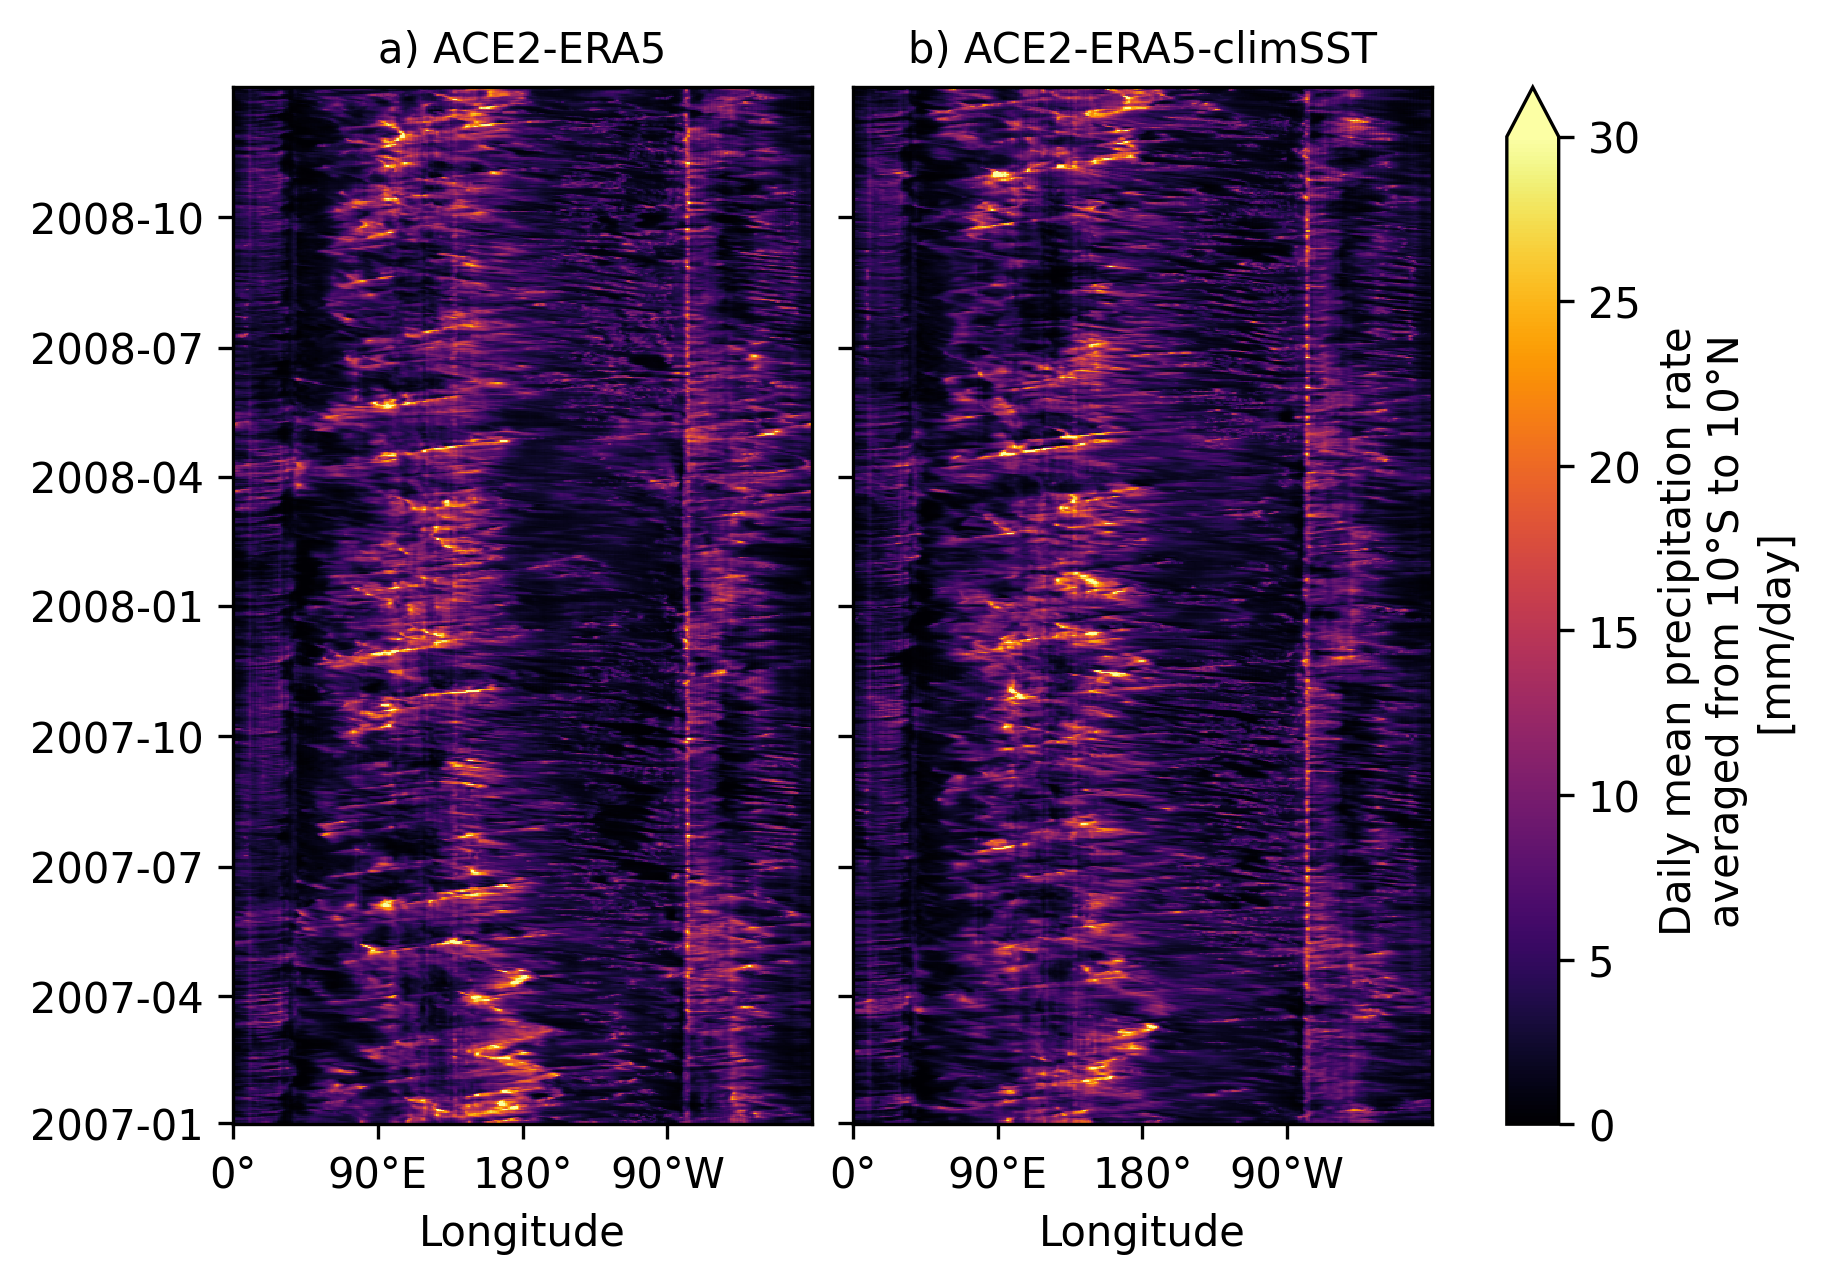

In [11]:
fg_hov = tropical_precip.sel(time=slice('2007', '2008')).plot(y='time', col='source', vmin=0, vmax=30, cmap='inferno')
fg_hov.fig.set_size_inches((6, 5))
fg_hov.set_titles(template='{value}')
fg_hov.set_ylabels('')
fg_hov.set_xlabels('Longitude')
for ax in fg_hov.axs.flat:
    ax.set_xticks([0, 90, 180, 270], labels=['0°', '90°E', '180°', '90°W'])
fg_hov.fig.savefig('figures/era5_daily_tropical_precip_climSST.png', bbox_inches='tight', transparent=True, dpi=300)


In [12]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=1)
    return y

In [13]:
low_period = 20  # in days
high_period = 100
filtered = tropical_precip.copy(deep=True)
filtered.values = butter_bandpass_filter(tropical_precip, 1/high_period, 1/low_period, 1.0)
filtered.attrs['long_name'] = f"{low_period}-{high_period} day bandpass filtered precipitation rate averaged from 10°S to 10°N"

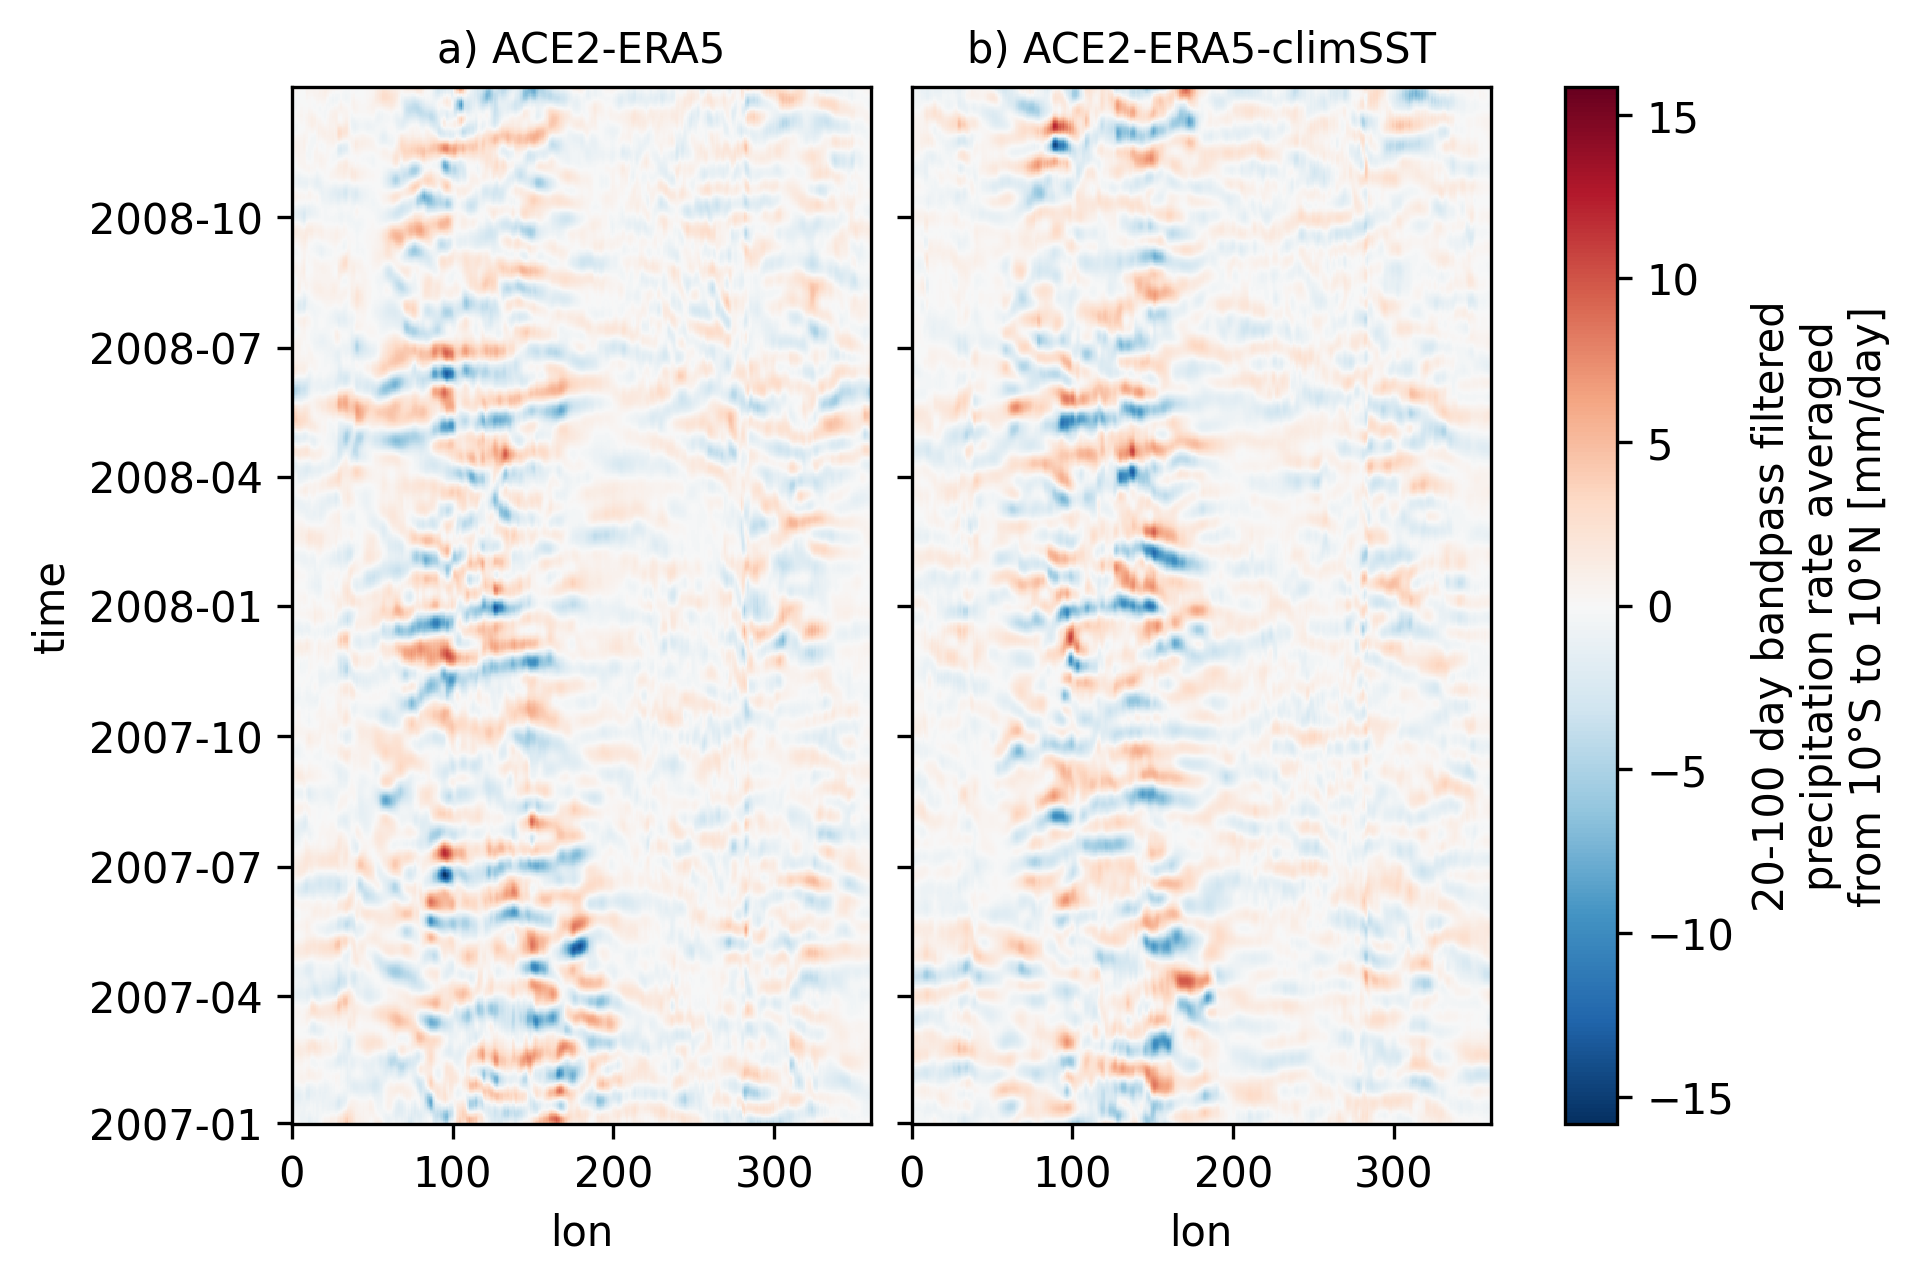

In [14]:
fg = filtered.sel(time=slice('2007', '2008')).plot(col='source')
fg.fig.set_size_inches((6, 5))
fg.set_titles(template='{value}')

In [15]:
def compute_lag_correlation(da, lon_slice, n_days=20):
    lag_correlations = []
    for day in range(-n_days, n_days + 1):
        x = da.sel(lon=lon_slice).mean('lon').shift(time=day)
        y = da
        lag_corr = xr.corr(x, y, dim='time')
        lag_correlations.append(lag_corr.assign_coords(lag=day))
    lag_correlations = xr.concat(lag_correlations, dim='lag')
    lag_correlations['lag'].attrs['units'] = 'days'
    lon_label = f'{lon_slice.start}°E-{lon_slice.stop}°E'
    lag_correlations.attrs['long_name'] = f'Lag correlation on precipitation at {lon_label}'
    return lag_correlations

### Compute and plot correlations with filtered data

In [16]:
lag_correlations = compute_lag_correlation(filtered, slice(80, 100), n_days=30)
lag_correlations.attrs['long_name'] = 'Lag correlation of 20-100 day tropical precipitation rate on 80°E-100°E precipitation'

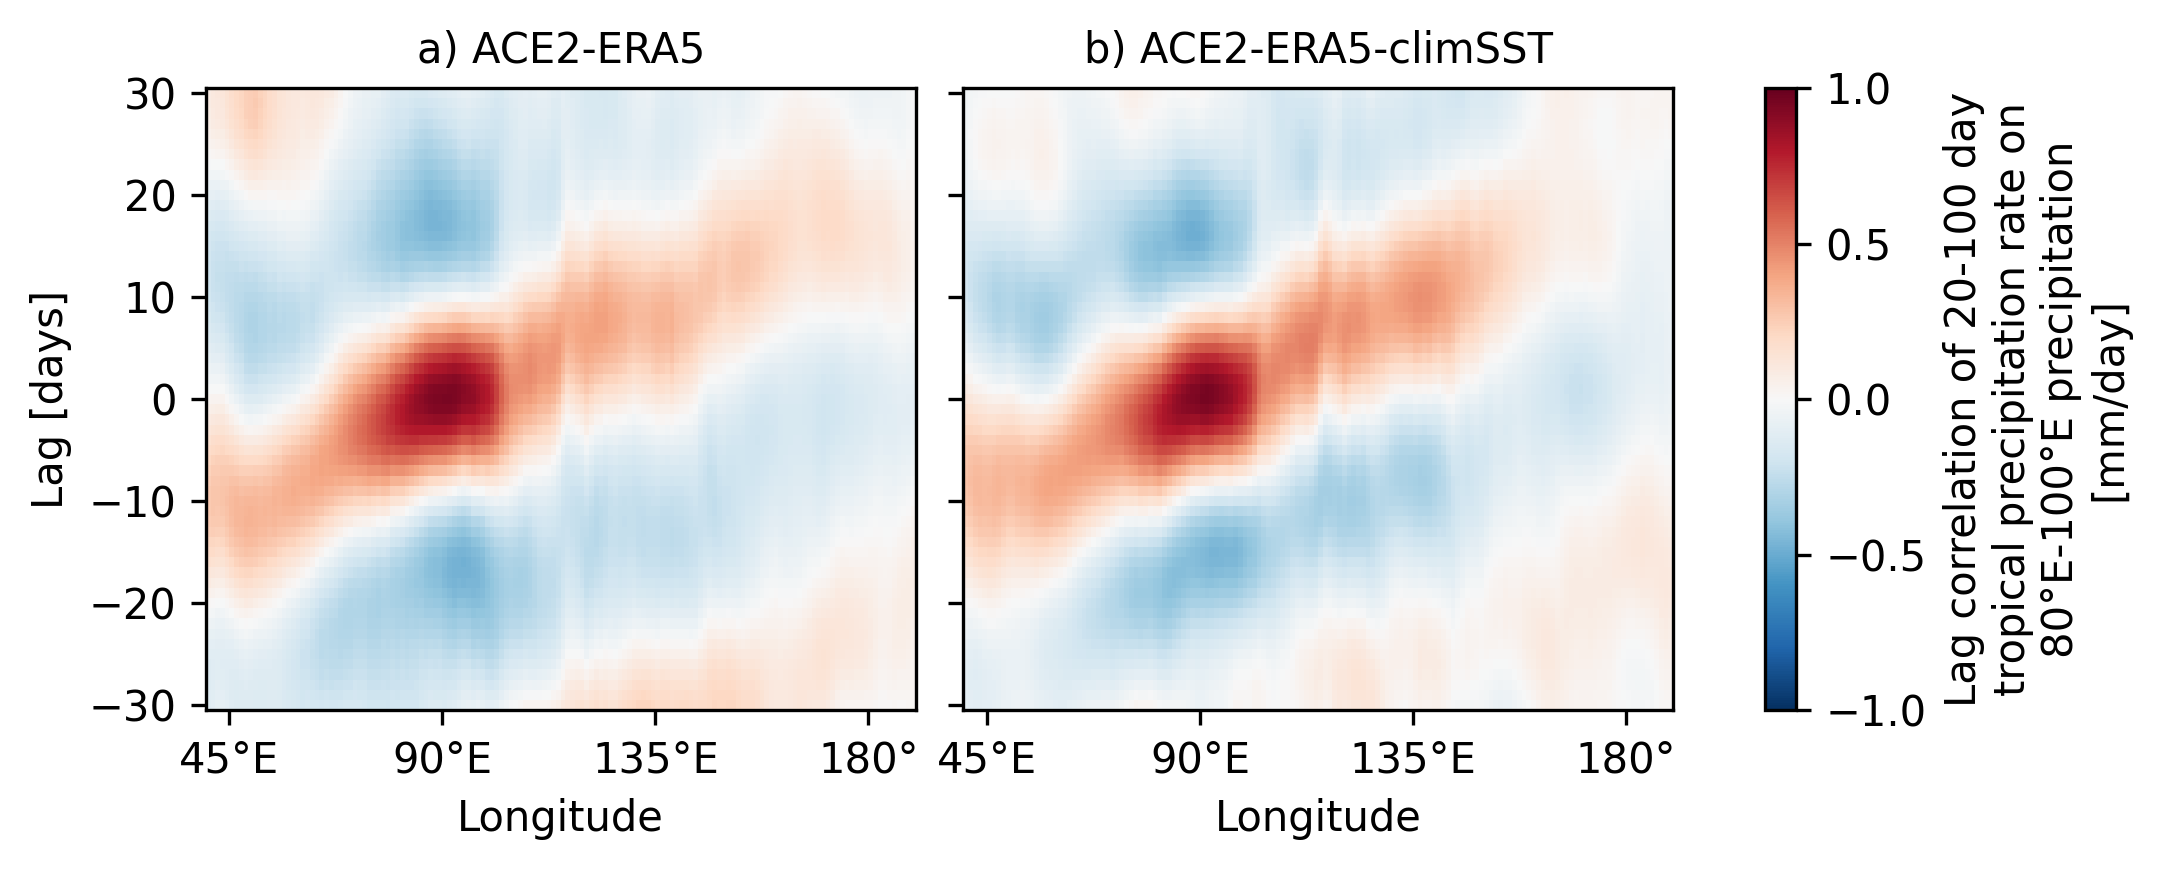

In [17]:
fg_lag = lag_correlations.plot(col='source', xlim=[40, 190], vmin=-1, vmax=1, cmap='RdBu_r')
fg_lag.set_ylabels('Lag [days]')
fg_lag.set_xlabels('Longitude')
for ax in fg_lag.axs.flat:
    ax.set_xticks([45, 90, 135, 180], labels=['45°E', '90°E', '135°E', '180°'])
fg_lag.set_titles(template='{value}')
fg_lag.fig.savefig('figures/era5_tropical_precip_lag_correlation_climSST.png', bbox_inches='tight', transparent=True, dpi=300)